In [1]:
! [ -e /content ] && pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz

In [2]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import cross_val_score
from IPython.display import Image, display_svg, SVG

min_samples_leaf_param = 50
max_features_param = 'sqrt'
num_est = 80
validation_lookback = 14
train_start_days_past = 94
should_drop_prior_gst = True

In [3]:
path = Path.cwd()
Path.BASE_PATH = path
dsets_path = path.parent.parent/'fastai/datasets'
path.ls()

(#5) [Path('preprocessed_train_valid.pkl'),Path('random_forest.ipynb'),Path('.ipynb_checkpoints'),Path('decision_tree.ipynb'),Path('default')]

In [4]:
df = pd.read_csv(dsets_path/'osrs_trades.csv', low_memory=False)
dep_var = 'gst'
make_date(df, 'timestamp')
df = add_datepart(df, 'timestamp')
df = df.drop('id', axis=1)
if should_drop_prior_gst:
    df = df.drop('prior_gst', axis=1)
df.columns

/home/tristan/Documents/dev/ML_exercises/random_forest/default/lib/python3.12/site-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)


Index(['item_name', 'item_id', 'gst', 'player_count', 'high_price_5m',
       'low_price_5m', 'high_volume_5m', 'low_volume_5m', 'high_price_1h',
       'low_price_1h', 'high_volume_1h', 'low_volume_1h', 'vol_ratio_1h',
       'vol_ratio_5m', 'price_ratio_5m', 'price_ratio_1h', 'avg_price_5m',
       'avg_price_1h', 'high_vol_ratio', 'low_vol_ratio', 'high_price_ratio',
       'low_price_ratio', 'avg_price_ratio', 'timestampYear', 'timestampMonth',
       'timestampWeek', 'timestampDay', 'timestampDayofweek',
       'timestampDayofyear', 'timestampIs_month_end',
       'timestampIs_month_start', 'timestampIs_quarter_end',
       'timestampIs_quarter_start', 'timestampIs_year_end',
       'timestampIs_year_start', 'timestampElapsed'],
      dtype='object')

In [5]:
procs = [Categorify, FillMissing]
maxDay = df['timestampDayofyear'].max()
maxDay

214

In [6]:
minCond = (df.timestampDayofyear>(maxDay - train_start_days_past)) # day 117 is when I fixed date recording on completed_trades
maxCond = (df.timestampDayofyear<=(maxDay - validation_lookback))
train_idx = np.where((maxCond) & (minCond))[0]
valid_idx = np.where(~maxCond)[0]

splits = (list(train_idx),list(valid_idx))
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)
save_pickle(path/'preprocessed_train_valid.pkl', to)

/home/tristan/Documents/dev/ML_exercises/random_forest/default/lib/python3.12/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
/home/tristan/Documents/dev/ML_exercises/random_forest/default/lib/python3.12/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never w

In [7]:
to = load_pickle(path/'preprocessed_train_valid.pkl')

In [8]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [9]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)
def accuracy(pred, y): return round(abs(y - pred).mean(), 2)
def m_accuracy(m, xs, y): return accuracy(m.predict(xs), y)

In [10]:
def rf(xs, y, n_estimators=num_est,
       max_features=max_features_param, min_samples_leaf=min_samples_leaf_param, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [11]:
m = rf(xs, y)

In [12]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

/home/tristan/Documents/dev/ML_exercises/random_forest/default/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/tristan/Documents/dev/ML_exercises/random_forest/default/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/tristan/Documents/dev/ML_exercises/random_forest/default/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/tristan/Documents/dev/ML_exercises/random_forest/default/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/tristan/Documents/dev/ML_exercises/random_forest/default/lib/python3.12/site-packages/sklearn/base.py:

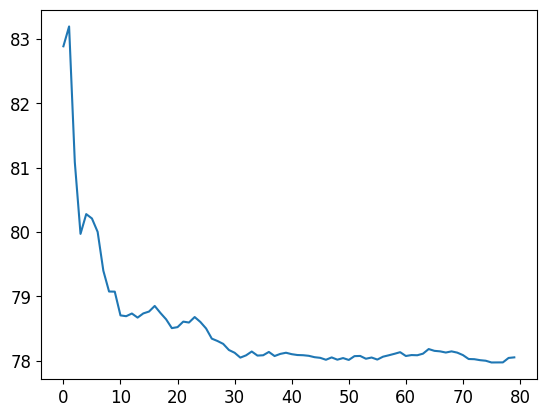

In [13]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(num_est)]);

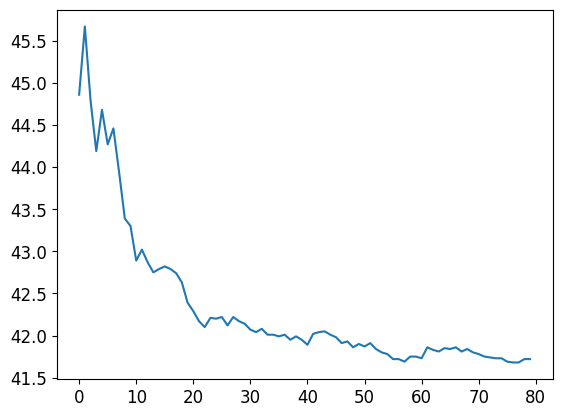

In [14]:
plt.plot([accuracy(preds[:i+1].mean(0), valid_y) for i in range(num_est)]);

In [15]:
r_mse(m.oob_prediction_, y)

178.294709

In [16]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [17]:
fi = rf_feat_importance(m, xs)

In [18]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [19]:
to_keep = fi[fi.imp>0.005].cols
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]
m = rf(xs_imp, y)
m_rmse(m, valid_xs_imp, valid_y), m_accuracy(m, valid_xs_imp, valid_y)

(77.673069, 41.72)

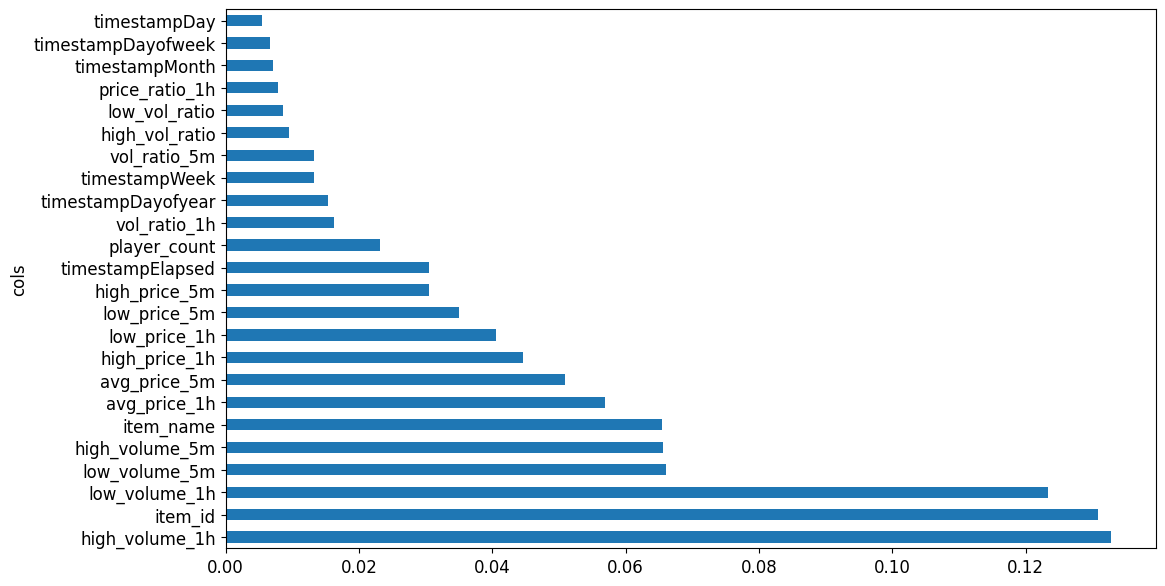

In [20]:
plot_fi(rf_feat_importance(m, xs_imp));

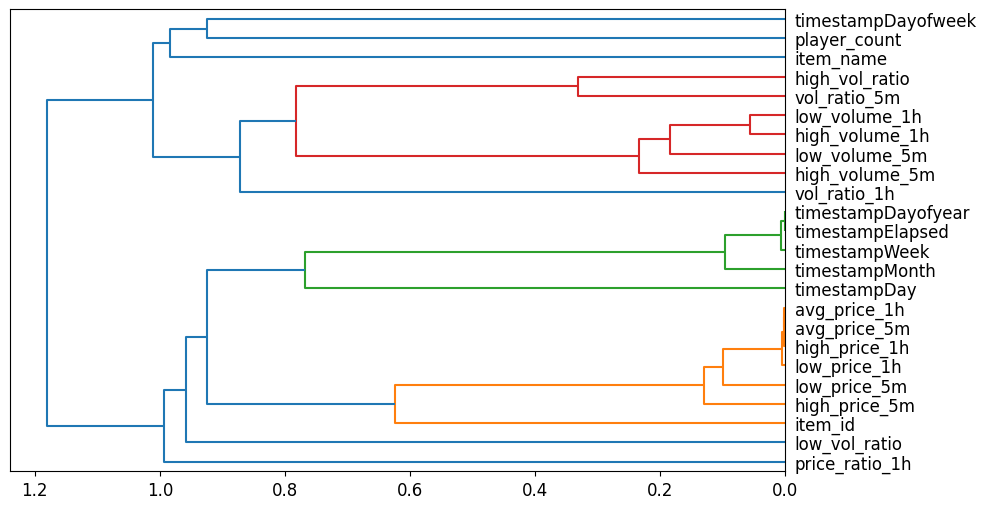

In [21]:
cluster_columns(xs_imp)

In [22]:
m.predict(valid_xs_imp.head(n=10))

array([ 48.60108052,  23.09388807, 135.68623774,  98.23345119,  50.34517946, 223.32938743,  44.90576358,  17.35526052,  51.91038305,  53.41662863])

In [23]:
valid_y.head(n=10)

10674     54.570000
10675     23.209999
10676      7.720000
10677    306.480011
10678     68.570000
10679    119.129997
10680     80.000000
10681      0.340000
10682     43.680000
10683     52.169998
Name: gst, dtype: float32